In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [5]:
data_dir = "/home/dat/Workspace/Thesis/lettuce_predictor/data/rasters_csv"

## Load data and calculate indices

In [126]:
df = pd.DataFrame()
for fname in os.listdir(data_dir):
    if fname.endswith("csv"):
         df = df.append(pd.read_csv(os.path.join(data_dir, fname)), ignore_index=True)
            
df.describe()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,240.000000,480.000000,480.000000
mean,43.750000,43.750000,2.000000,187.400000,43.515833,0.811986,-1.774208,15.458333,14.758333
std,37.014075,37.014075,0.817348,39.776075,6.090281,0.043860,1.466062,5.858307,5.172588
min,0.000000,0.000000,1.000000,104.000000,1.200000,0.126831,-4.950000,4.000000,5.000000
25%,18.750000,18.750000,1.000000,201.000000,39.775000,0.795598,-2.710000,11.000000,11.000000
50%,37.500000,37.500000,2.000000,203.500000,43.400000,0.816542,-1.165000,15.000000,15.000000
75%,62.500000,62.500000,3.000000,211.000000,47.625000,0.836362,-0.740000,19.000000,19.000000
max,100.000000,100.000000,3.000000,214.000000,60.900000,0.876963,-0.400000,35.000000,25.000000


In [140]:
channel_vals = []
for id, row in df.iterrows():
    raster = np.load(row["img_path"])
    # Crop border to only get plant in image
    # raster = raster[1:-1, 1:-1]
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    channel_vals.append([b, g, r, re, nir])
    
df["channel_vals"] = channel_vals

In [128]:
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,img_path,channel_vals
0,0,0,1,104,48.9,0.805878,-4.80,6,7,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.24857644703653123, 0.34114080948962106, 0.2..."
1,0,0,1,113,44.4,0.815393,NaN,6,7,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.23450525974233946, 0.36158036161214113, 0.1..."
2,0,0,2,104,48.8,0.839747,-4.24,4,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.25269621460124697, 0.37957831374322526, 0.2..."
3,0,0,2,113,53.5,0.819832,NaN,4,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.21367022653038686, 0.33464863523840904, 0.1..."
4,0,0,3,104,51.9,0.812323,-4.82,7,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.15233559229157187, 0.24997904659672218, 0.1..."


## Analyze distribution of ground truth

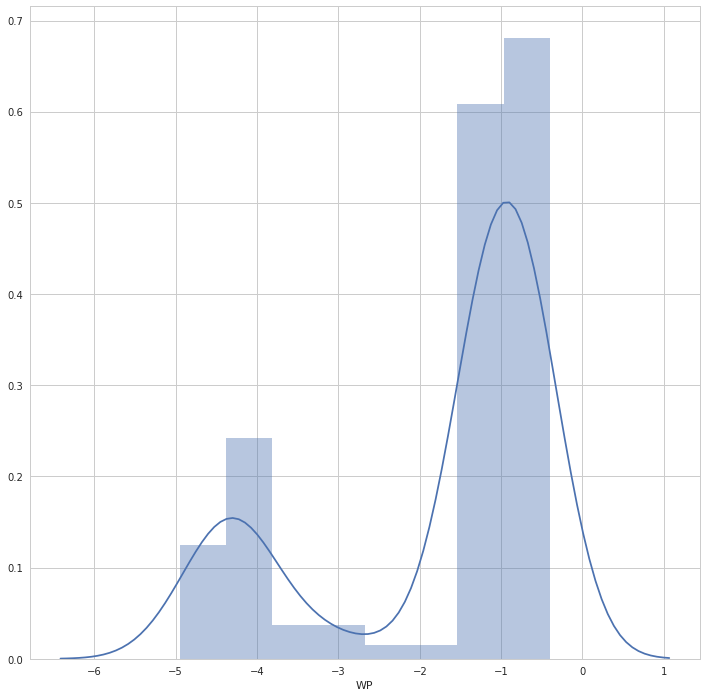

In [81]:
sns.distplot(df["WP"].dropna())

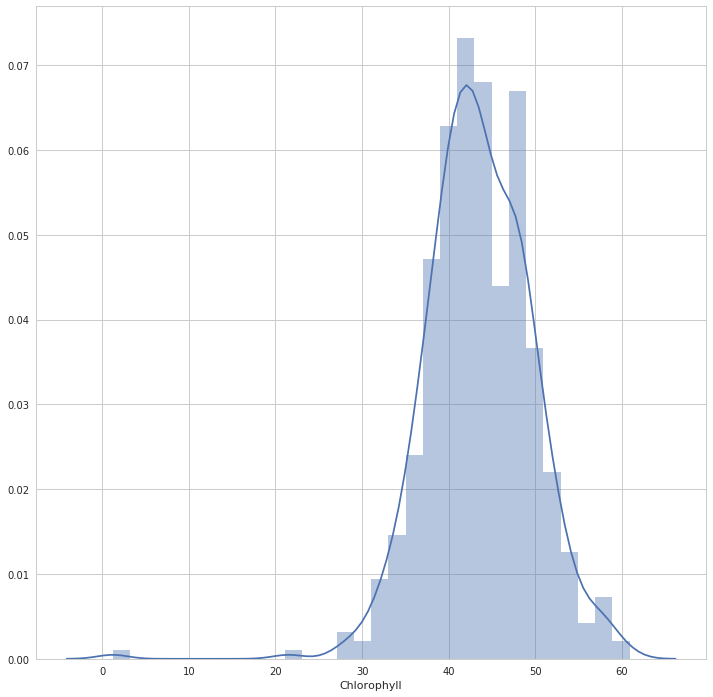

In [82]:
sns.distplot(df["Chlorophyll"])

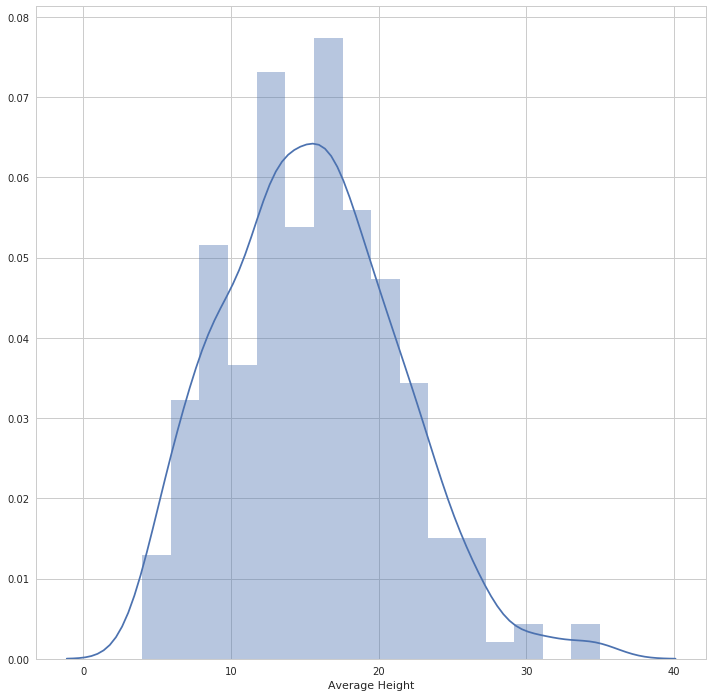

In [83]:
sns.distplot(df["Average Height"])

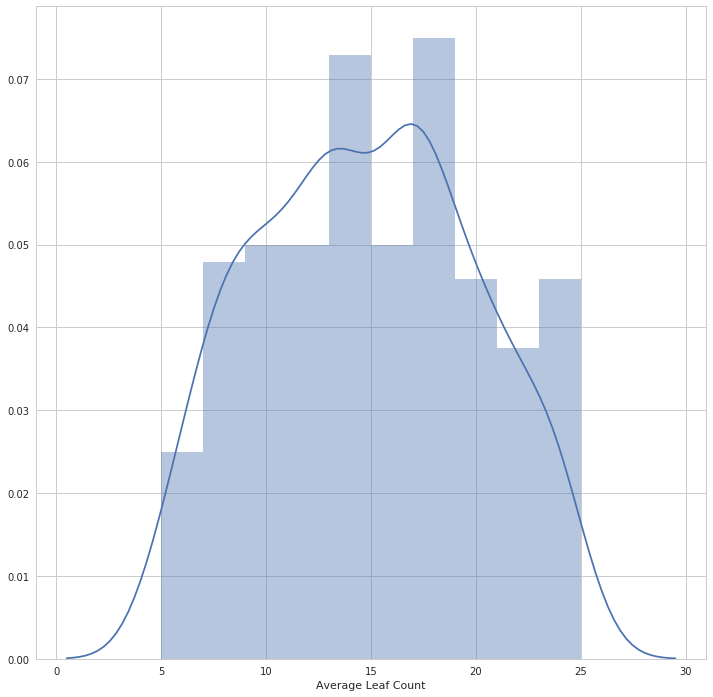

In [84]:
sns.distplot(df["Average Leaf Count"])

## Predictive Models

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [41]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def normalize(xs):
    max_x = max(xs)
    min_x = min(xs)
    return [(x-min_x)/(max_x-min_x) for x in xs]

RMSE: 0.320356577430295
MAE: 0.26408687850458856
R2: 0.007343505220107738


Text(0,0.5,'Predicted WP')

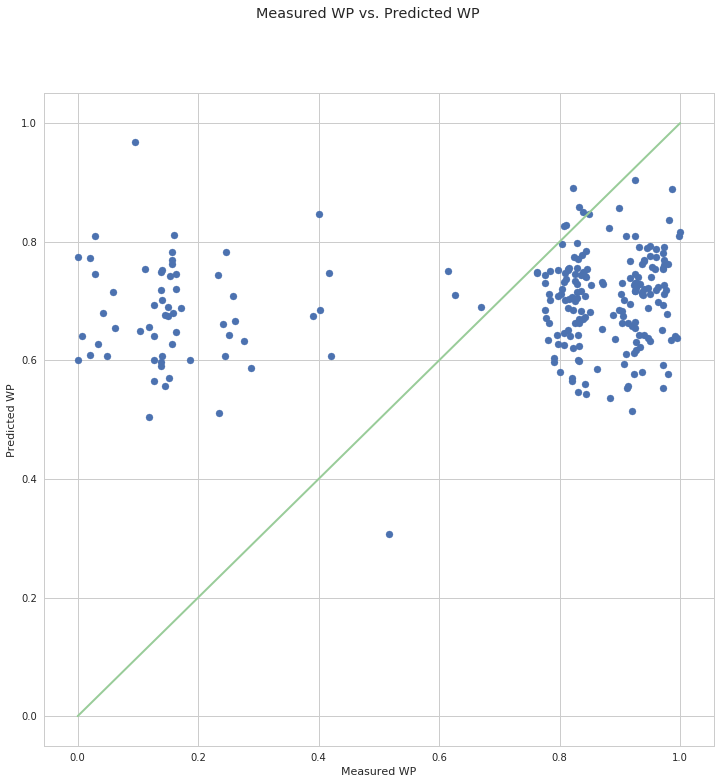

In [87]:
X = np.array(list(df.dropna()["channel_vals"]))
y = np.array(normalize(list(df.dropna()["WP"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured WP vs. Predicted WP")
plt.xlabel("Measured WP")
plt.ylabel("Predicted WP")

RMSE: 0.09551645391939315
MAE: 0.07322839850577552
R2: 0.12151146495901899


Text(0,0.5,'Predicted Chlorophyll')

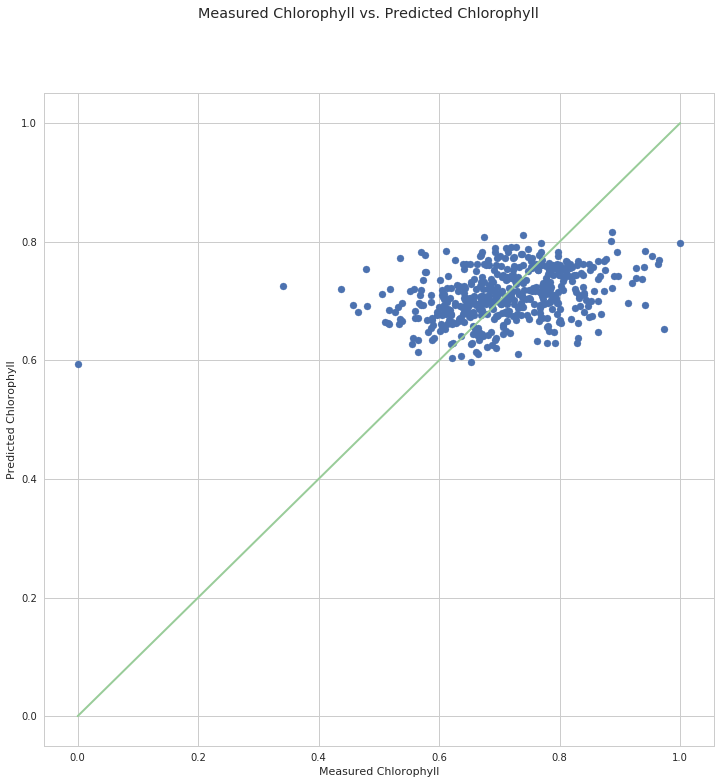

In [100]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Chlorophyll"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Chlorophyll vs. Predicted Chlorophyll")
plt.xlabel("Measured Chlorophyll")
plt.ylabel("Predicted Chlorophyll")

RMSE: 0.12088068445963483
MAE: 0.0926258684256572
R2: 0.5899860364938455


Text(0,0.5,'Predicted Plant Height')

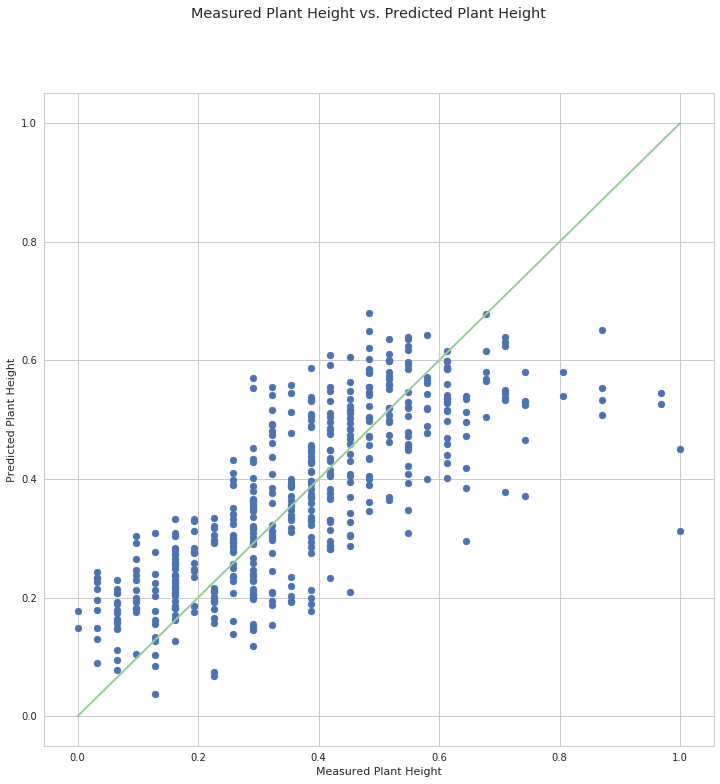

In [99]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Average Height"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Plant Height vs. Predicted Plant Height")
plt.xlabel("Measured Plant Height")
plt.ylabel("Predicted Plant Height")

RMSE: 0.16776926241170986
MAE: 0.1337166176572804
R2: 0.5783281106053273


Text(0,0.5,'Predicted Leaf Count')

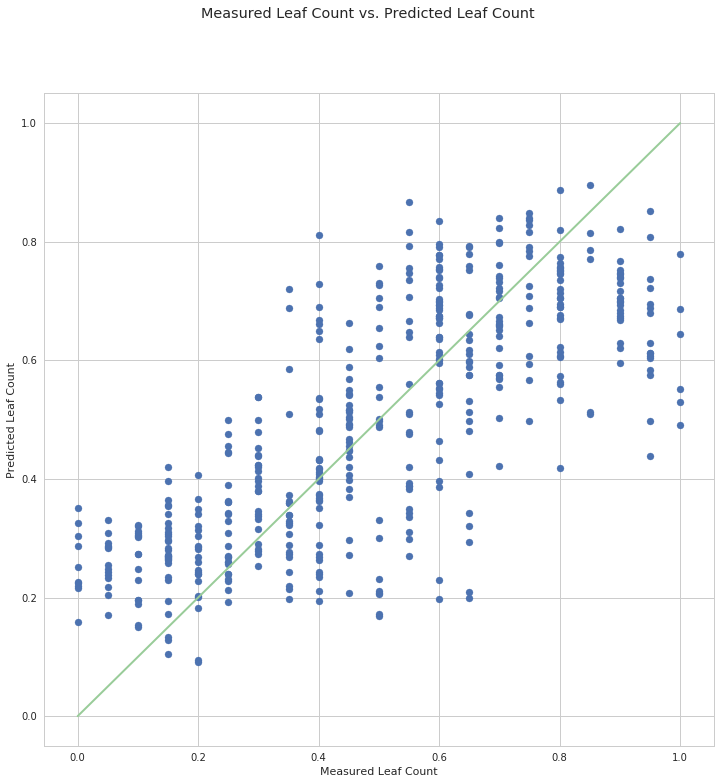

In [97]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Average Leaf Count"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Leaf Count vs. Predicted Leaf Count")
plt.xlabel("Measured Leaf Count")
plt.ylabel("Predicted Leaf Count")

In [142]:
from sklearn.ensemble import RandomForestClassifier

X = np.array(list(df["channel_vals"]))
y = ["N{}IR{}".format(n, ir) for n, ir in zip(df["Nitrogen"], df["Irrigation"])]

X, y = shuffle(X, y)

model = RandomForestClassifier()
predicted = cross_val_predict(model, X, y, cv=10)
print(np.mean(predicted == y))

0.08958333333333333
